# Beacons detection

- Image processing 
    - Set connection to webcam
    - Aquire image 
    - Process image 
    - Get beacons

### Imports

In [ ]:
#Imports
import math 
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2 as cv
import argparse
from tqdm import tqdm
import usb.core
import usb.util 
#import imutils
import time 
from scipy.spatial import distance as dist
from collections import OrderedDict

Access USB and take/save photo manually -> to AUTOMATIC for final version

In [3]:
#Find device 
webcam = cv.VideoCapture(0) #ID 0

if not (webcam.isOpened()):
    print("Could not open video device")

cv.startWindowThread()

while True:
    try:
        key = cv.waitKey(1)
        check, frame = webcam.read()
        cv.imshow("Capturing", frame)
        if key == ord('s'): 
            cv.imwrite(filename='final8.jpg', img=frame)
            webcam.release()

            cv.waitKey(1)
            cv.destroyAllWindows()
            cv.waitKey(1)
            print("Processing image...")
            #img_ = cv2.imread('saved_img.jpg', cv2.IMREAD_ANYCOLOR)
            print("Converting RGB image to grayscale...")
            #gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
            print("Converted RGB image to grayscale...")
            print("Resizing image to 28x28 scale...")
            #img_ = cv2.resize(gray,(28,28))
            print("Resized...")
            #img_resized = cv2.imwrite(filename='saved_img-final.jpg', img=img_)
            print("Image saved!")
        
            break
        elif key == ord('q'):
            print("Turning off camera.")
            webcam.release()
            print("Camera off.")
            print("Program ended.")
            cv.destroyAllWindows()
            key
            break 
        
    except(KeyboardInterrupt):
        print("Turning off camera.")
        webcam.release()
        print("Camera off.")
        print("Program ended.")
        cv.destroyAllWindows()
        key
        break

Turning off camera.
Camera off.
Program ended.


## Functions

In [4]:
class ColorLabeler:
    def __init__(self):
        # initialize the colors dictionary, containing the color
        # name as the key and the RGB tuple as the value
        colors = OrderedDict({
            "red": (255, 0, 0),
            "green": (0, 255, 0),
            "blue": (0, 0, 255)})
        # allocate memory for the L*a*b* image, then initialize
        # the color names list
        self.lab = np.zeros((len(colors), 1, 3), dtype="uint8")
        self.colorNames = []
        # loop over the colors dictionary
        for (i, (name, rgb)) in enumerate(colors.items()):
            # update the L*a*b* array and the color names list
            self.lab[i] = rgb
            self.colorNames.append(name)
        # convert the L*a*b* array from the RGB color space
        # to L*a*b*
        self.lab = cv.cvtColor(self.lab, cv.COLOR_RGB2LAB)


    def label(self, image, c):
        # construct a mask for the contour, then compute the
        # average L*a*b* value for the masked region
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv.drawContours(mask, [c], -1, 255, -1)
        kernel = np.ones((5,5),np.uint8)
        mask = cv.erode(mask, kernel, iterations=2)
        mean = cv.mean(image, mask=mask)[:3]
        # initialize the minimum distance found thus far
        minDist = (np.inf, None)
        # loop over the known L*a*b* color values
        for (i, row) in enumerate(self.lab):
            # compute the distance between the current L*a*b*
            # color value and the mean of the image
            d = dist.euclidean(row[0], mean)
            # if the distance is smaller than the current distance,
            # then update the bookkeeping variable
            if d < minDist[0]:
                minDist = (d, i)
        # return the name of the color with the smallest distance
        return self.colorNames[minDist[1]]


def detect(c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.04 * peri, True)    # normally between 1% and 5%
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv.boundingRect(approx)
            ar = w / float(h) # aspect ration to distinguish if square ≈ 1 or rectangle 
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

## Image processing 

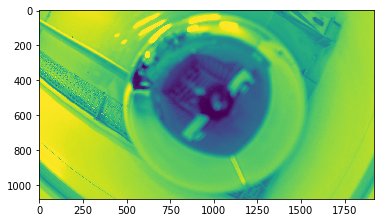

[[[ 591.14996    66.149994  610.8     ]
  [  59.85      838.94995   472.2     ]
  [ 605.85      589.05      503.7     ]
  [1072.0499    820.05      876.24    ]]]
591 66 611
60 839 472
606 589 504
1072 820 876


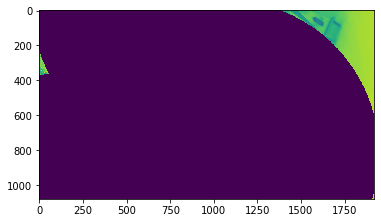

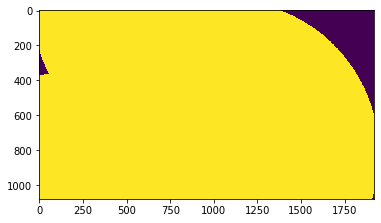

In [11]:
t0 = time.time()

# load image RGB
img = plt.imread('final8.jpg')
output = img.copy()

#CHECK IF IMAGE ROTATION IS NEEDED

# load image BGR
img_BGR = cv.imread('final8.jpg')  

# convert to grayscale
gray = cv.cvtColor(img_BGR, cv.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

# masking region of no interest -> everything outside sphere  
# detect circles (attention to parameters)
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 2.1, 500, minRadius = 300, maxRadius = 1000)
print(circles) # print how many circles are found 

# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (xc, yc, r) in circles:
        print(xc,yc,r)
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv.circle(gray, (xc, yc), r, (0, 255, 0), -1)
        #cv.rectangle(gray, (xc - 5, yc - 5), (xc + 5, yc + 5), (0, 128, 255), -1)
    # show the output image
    plt.imshow(gray)
    plt.show()

# extract mask
ret,mask = cv.threshold(gray,10,255, cv.THRESH_BINARY_INV)
plt.imshow(mask)
plt.show() 

# # apply mask on original frame 
# result_mask = cv.bitwise_and(img_BGR, img_BGR, mask=mask)
# plt.imshow(result_mask)
# plt.show() 

# # apply mask on original frame 
# result_img = cv.bitwise_and(img, img, mask=mask)
# plt.imshow(result_img)
# plt.show() 

# # remove some noise 
# blurred = cv.GaussianBlur(result_mask, (5,5), 0)

# # Convert BGR to HSV
# hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

# # define range of red color in HSV
# lower_red = np.array([0,50,50])  
# upper_red = np.array([20,255,255])
# lower_red2 = np.array([160,50,50])  
# upper_red2 = np.array([180,255,255])

# # define range of yellow color in HSV
# lower_yellow = np.array([20,20,50])
# upper_yellow = np.array([60,255,255])

# # define range of green color in HSV
# lower_green = np.array([50,50,50])
# upper_green = np.array([100,255,255])

# # define range of blue color in HSV
# lower_blue = np.array([100,50,50])
# upper_blue = np.array([140,255,255])

# # Threshold the HSV image to get only yellow colors
# mask_Yellow = cv.inRange(hsv, lower_yellow, upper_yellow)

# # Threshold the HSV image to get only yellow colors
# mask_Red = cv.inRange(hsv, lower_red, upper_red)
# mask_Red2 = cv.inRange(hsv, lower_red2, upper_red2)

# # Threshold the HSV image to get only green colors
# mask_Green = cv.inRange(hsv, lower_green, upper_green)

# # Threshold the HSV image to get only blue colors
# mask_Blue = cv.inRange(hsv, lower_blue, upper_blue)

# # highlight only bright elements in result_mask
# thresh_res = cv.threshold(result_mask, 225, 255, cv.THRESH_BINARY)[1]
# print("thresholded result")
# plt.imshow(thresh_res)
# plt.show()


# # Bitwise-AND mask 
# res_Y = cv.bitwise_and(thresh_res,thresh_res, mask= mask_Yellow)
# print("yellow mask")
# plt.imshow(res_Y)
# plt.show()

# # Bitwise-AND mask 
# res_R = cv.bitwise_and(thresh_res,thresh_res, mask= mask_Red)
# print("red mask")
# plt.imshow(res_R)
# plt.show()

# # Bitwise-AND mask 
# res_R2 = cv.bitwise_and(thresh_res,thresh_res, mask= mask_Red2)
# print("red mask 2")
# plt.imshow(res_R2)
# plt.show()

# # Bitwise-AND mask 
# res_G = cv.bitwise_and(thresh_res,thresh_res, mask= mask_Green)
# print("green mask")
# plt.imshow(res_G)
# plt.show()

# # Bitwise-AND mask 
# res_B = cv.bitwise_and(thresh_res,thresh_res, mask= mask_Blue)
# print("blue mask")
# plt.imshow(res_B)
# plt.show()
   
# # Sum all masks 
# res = res_Y + res_R + res_R2 + res_G + res_B

# # Morphological operation
# kernel = np.ones((3,3),np.uint8)
# erode = cv.erode(res, kernel, iterations = 1)
# print('erode')
# plt.imshow(erode)
# plt.show()

# kernel = np.ones((9,9),np.uint8)
# dilate = cv.dilate(erode, kernel, iterations = 1)
# print('dilate')
# plt.imshow(dilate)
# plt.show()

# # Grayscale image 
# res_gray = cv.cvtColor(dilate, cv.COLOR_BGR2GRAY)
# plt.imshow(res_gray)
# plt.show()

# # Bitwise mask to original image
# final_img = cv.bitwise_and(img, img, mask=res_gray)
# plt.imshow(final_img)
# plt.show() 
    
# # CIELAB color space 
# lab = cv.cvtColor(final_img, cv.COLOR_RGB2LAB)

# # find contours in the thresholded image
# cnts = cv.findContours(res_gray.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)

# # object ColorLabeler to label color of feature 
# cl = ColorLabeler()

# # loop over the contours
# for c in cnts:
#     # compute the center of the contour
#     M = cv.moments(c) # image moment
#     if(M["m00"] > 50): #and M["m00"] < 6000):   # would like to remove upper bound -> HAT
#         cX = int(M["m10"] / M["m00"]) #* ratio)
#         cY = int(M["m01"] / M["m00"]) #* ratio)
#         shape = detect(c)
#         #if(shape == 'rectangle' or shape == 'pentagon'):
#         color = cl.label(lab, c) # should be lab instead of hsv

#         if(color == 'red'):
#             clr = [255, 0, 0]
#         elif(color == 'green'):
#             clr = [0, 255, 0]
#         elif(color == 'blue'):
#             clr = [0, 0, 255]
#         elif(clr == 'yellow'):
#             clr = [255, 255, 0]
#         # multiply the contour (x, y)-coordinates by the resize ratio,
#         # then draw the contours and the name of the shape and labeled
#         # color on the image
#         #c = c.astype("float")
#         #c *= ratio
#         #c = c.astype("int")
#         text = "{} {}".format(color, shape)
#         # draw the contour and center of the shape on the image
#         cv.drawContours(output, [c], -1, clr, 2)
#         cv.putText(output, text, (cX, cY - 50) ,cv.FONT_HERSHEY_SIMPLEX, 2, clr, 5)
#         cv.circle(output, (cX, cY), 7,  (0, 0, 0), -1)
#         cv.putText(output, "center", (cX + 20, cY + 20),cv.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3)
# plt.imshow(output)
# plt.show()
# plt.imshow(img)
# plt.show()
# t_elapsed = time.time() - t0
# print("Time elapsed: ", t_elapsed)


In [11]:
desiredColor = np.uint8([[[0,0,255 ]]])
hsv_Color = cv.cvtColor(desiredColor,cv.COLOR_RGB2HSV)
print( hsv_Color )

[[[120 255 255]]]


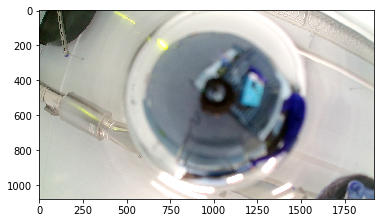

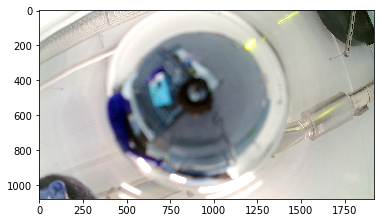

In [113]:
frame = cv.imread('greenBeacon.jpg')  
frame2 = frame[:, ::-1,:]
plt.imshow(frame)
plt.show()
plt.imshow(frame2)
plt.show()